# Analyze Ball on Incline data
Use this notebook to quickly test whether your ball on incline data makes sense!

In [113]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import os
from IPython.core.display import Latex
from sympy import *
from scipy.stats import chi2
from scipy.optimize import curve_fit

## Reading the data

The function "read_csv(filename)" takes in a filename and returns numpy arrays with time and voltage.

In [114]:
def read_csv(filename):
    """Read CSV from Waveforms"""
    dat = np.genfromtxt(filename, delimiter=',', skip_header=13, names=True)
    time = dat['Time_s']
    voltage = dat['Channel_1_V']
    return time, voltage

def find_midpoints(time, voltage, show_plot=True):
    """Find timing of ball crossings"""
    
    
    # Write a function yourself, which identifies the peaks in the voltage,
    # and returns values for passing times and (possibly) their uncertainties
    # in it (but they are generally very small!).

    time = np.array(time)
    voltage = np.array(voltage)

    threshold = 0.5 * (np.max(voltage) + np.min(voltage))

    # 2. Boolean mask: True while peak is high
    high = voltage > threshold

    # 3. Find rising and falling edges of the high regions
    edges = np.diff(high.astype(int))

    start_indices = np.where(edges == +1)[0] + 1   # rising edges
    end_indices   = np.where(edges == -1)[0]       # falling edges

    # Handle case where signal starts or ends high
    if high[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if high[-1]:
        end_indices = np.append(end_indices, len(high)-1)

    # 4. Compute center times for each peak
    peak_centers = (time[start_indices] + time[end_indices]) / 2
   

    t_pass = np.array(peak_centers)
    t_pass_sigma = np.full_like(t_pass, 0.00001)    
    if show_plot:
        plt.plot(time, voltage, label='Voltage signal')
        plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
        plt.scatter(t_pass, np.full_like(t_pass, threshold), color='green', label='Detected Passings')
        plt.errorbar(t_pass, np.full_like(t_pass, threshold), yerr=t_pass_sigma, fmt='o', color='green')
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)')
        plt.xlim(time[0], .6)
        plt.title('Ball on Incline Voltage Signal with Detected Passings')
        plt.legend()
        plt.show()
    


    
    return t_pass, t_pass_sigma

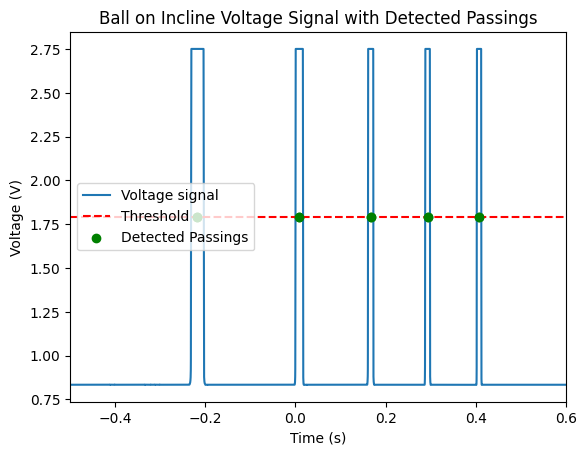

In [115]:
# Read the data and plot it (possibly with passing times in):
filename = 'ball_big_1.csv'

time, voltage = read_csv(filename)
timepass, timepass_sig = find_midpoints(time, voltage)


In [116]:
blinded = False          # Add a random (but fixed) offset to the 30cm and 2m data seperately

r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)


In [117]:
def weighted_mean(a,s):
    """Compute weighted mean and its uncertainty"""
    a = np.asarray(a, dtype=float)
    s = np.asarray(s, dtype=float)
    w = 1 / s**2
    wmean = np.sum(w * a) / np.sum(w)
    wmean_err = np.sqrt(1 / np.sum(w))
    return wmean, wmean_err

In [118]:
# Positions of photodetectors in meters
x_positions = np.array([8.45567020250723, 23.390549662487942, 38.54252651880424,
                        53.46890067502411, 69.1189006750241]) * 0.01

# CSV file lists
big_ball_files = ['ball_big_1.csv', 'ball_big_2.csv', 'ball_big_3.csv', 'ball_big_4.csv',
                  'ball_big_5.csv', 'ball_big_6.csv', 'ball_big_7.csv', 'ball_big_8.csv']
big_ball_reversed_files = ['ball_big_reversed_1.csv', 'ball_big_reversed_2.csv', 'ball_big_reversed_3.csv',
                           'ball_big_reversed_4.csv', 'ball_big_reversed_5.csv']

med_balls_files = ['ball_med_1.csv', 'ball_med_2.csv', 'ball_med_3.csv', 'ball_med_4.csv', 'ball_med_5.csv']
med_balls_reversed_files = ['ball_med_reversed_1.csv', 'ball_med_reversed_2.csv', 'ball_med_reversed_3.csv',
                            'ball_med_reversed_4.csv', 'ball_med_reversed_5.csv']

small_balls_files = ['ball_small_1.csv', 'ball_small_2.csv', 'ball_small_3.csv', 'ball_small_4.csv', 'ball_small_5.csv']
small_balls_reversed_files = ['ball_small_reversed_1.csv', 'ball_small_reversed_2.csv', 'ball_small_reversed_3.csv',
                              'ball_small_reversed_4.csv', 'ball_small_reversed_5.csv']

# 1. Read CSV
def read_csv(filename):
    dat = np.genfromtxt(filename, delimiter=',', skip_header=13, names=True)
    time = dat['Time_s']
    voltage = dat['Channel_1_V']
    return time, voltage

# 2. Detect ball passings
def find_midpoints(time, voltage, show_plot=False):
    time = np.array(time)
    voltage = np.array(voltage)

    threshold = 0.5 * (np.max(voltage) + np.min(voltage))
    high = voltage > threshold
    edges = np.diff(high.astype(int))
    start_indices = np.where(edges == +1)[0] + 1
    end_indices   = np.where(edges == -1)[0]

    if high[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if high[-1]:
        end_indices = np.append(end_indices, len(high)-1)

    peak_centers = (time[start_indices] + time[end_indices]) / 2
    t_pass = np.array(peak_centers)
    t_pass_sigma = np.full_like(t_pass, 1e-5)

    if show_plot:
        plt.plot(time, voltage, label='Voltage')
        plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
        plt.scatter(t_pass, np.full_like(t_pass, threshold), color='green', label='Detected Passings')
        plt.errorbar(t_pass, np.full_like(t_pass, threshold), yerr=t_pass_sigma, fmt='o', color='green')
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)')
        plt.title('Ball Passings')
        plt.legend()
        plt.show()

    return t_pass, t_pass_sigma

# 3. Quadratic model
def quadratic(t, a, v0, s0):
    return 0.5 * a * t**2 + v0 * t + s0

# 4. Fit list of files and compute weighted mean
def get_accelerations(file_list, show_plot=False):
    accelerations = []
    accel_errors = []

    for f in file_list:
        try:
            time, voltage = read_csv(f)
            t_pass, t_pass_sigma = find_midpoints(time, voltage, show_plot=show_plot)
            if len(t_pass) != len(x_positions):
                print(f"Skipping {f}: detected {len(t_pass)} passings, expected {len(x_positions)}")
                continue

            popt, pcov = curve_fit(quadratic, t_pass, x_positions)
            a, v0, s0 = popt
            a_err = np.sqrt(np.diag(pcov))[0]

            accelerations.append(a)
            accel_errors.append(a_err)
        except Exception as e:
            print(f"Error processing {f}: {e}")

    accelerations = np.array(accelerations)
    accel_errors = np.array(accel_errors)

    # Weighted mean
    weights = 1 / accel_errors**2
    wmean = np.sum(accelerations * weights) / np.sum(weights)
    wmean_err = np.sqrt(1 / np.sum(weights))

    return wmean, wmean_err

# Compute accelerations per ball size and direction
a_big_wmean, a_big_wmean_err = get_accelerations(big_ball_files)
a_big_rev_wmean, a_big_rev_wmean_err = get_accelerations(big_ball_reversed_files)

a_med_wmean, a_med_wmean_err = get_accelerations(med_balls_files)
a_med_rev_wmean, a_med_rev_wmean_err = get_accelerations(med_balls_reversed_files)

a_small_wmean, a_small_wmean_err = get_accelerations(small_balls_files)
a_small_rev_wmean, a_small_rev_wmean_err = get_accelerations(small_balls_reversed_files)

# Print results
print("Big ball (normal): {:.5f} ± {:.5f} m/s²".format(a_big_wmean, a_big_wmean_err))
print("Big ball (reversed): {:.5f} ± {:.5f} m/s²".format(a_big_rev_wmean, a_big_rev_wmean_err))
print("Medium ball (normal): {:.5f} ± {:.5f} m/s²".format(a_med_wmean, a_med_wmean_err))
print("Medium ball (reversed): {:.5f} ± {:.5f} m/s²".format(a_med_rev_wmean, a_med_rev_wmean_err))
print("Small ball (normal): {:.5f} ± {:.5f} m/s²".format(a_small_wmean, a_small_wmean_err))
print("Small ball (reversed): {:.5f} ± {:.5f} m/s²".format(a_small_rev_wmean, a_small_rev_wmean_err))


Big ball (normal): 1.57068 ± 0.00171 m/s²
Big ball (reversed): 1.57558 ± 0.00205 m/s²
Medium ball (normal): 1.50137 ± 0.00224 m/s²
Medium ball (reversed): 1.50227 ± 0.00244 m/s²
Small ball (normal): 1.37945 ± 0.00373 m/s²
Small ball (reversed): 1.37501 ± 0.00284 m/s²


# Actual data analysis of g:

In [119]:
def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

In [120]:
# Doing it with the definition of Delta theta:

g, theta, D_ball, D_rail, a, a_norm, a_rev  = symbols("g, theta, D, d, a, a_norm, a_rev")
dg, dtheta, dD_ball, dD_rail, da, da_norm, da_rev = symbols("sigma_g, sigma_theta, sigma_D, sigma_d, sigma_a, sigma_a_norm, sigma_a_rev")
Delta_theta = (a_norm - a_rev)*sin(theta)/((a_norm + a_rev)*cos(theta))
dDelta_theta = Symbol(r'\sigma_{\Delta\theta}')

g_plus_Delta_Theta_def = a/sin(theta + Delta_theta) * (1 + Rational(2,5) * D_ball**2/(D_ball**2 - D_rail**2))

dg_plus_Delta_Theta_def = sqrt((g_plus_Delta_Theta_def.diff(theta) * dtheta)**2 
                        + (g_plus_Delta_Theta_def.diff(D_ball) * dD_ball)**2 
                        + (g_plus_Delta_Theta_def.diff(D_rail) * dD_rail)**2 
                        + (g_plus_Delta_Theta_def.diff(a) * da)**2
                        + (g_plus_Delta_Theta_def.diff(a_norm) * da_norm)**2
                        + (g_plus_Delta_Theta_def.diff(a_rev) * da_rev)**2)


g_minus_Delta_Theta_def = a/sin(theta - Delta_theta) * (1 + Rational(2,5) * D_ball**2/(D_ball**2 - D_rail**2))

dg_minus_Delta_Theta_def = sqrt((g_minus_Delta_Theta_def.diff(theta) * dtheta)**2 
                        + (g_minus_Delta_Theta_def.diff(D_ball) * dD_ball)**2 
                        + (g_minus_Delta_Theta_def.diff(D_rail) * dD_rail)**2 
                        + (g_minus_Delta_Theta_def.diff(a) * da)**2
                        + (g_minus_Delta_Theta_def.diff(a_norm) * da_norm)**2
                        + (g_minus_Delta_Theta_def.diff(a_rev) * da_rev)**2)

In [121]:
# Data from measurements:

diameter_ball_big = [
    (15, 0.05),
    (14.8, 0.1),
    (14.9, 0.15),
    (14.8, 0.2),
    (14.9, 0.1)
]

diameter_ball_medium = [
    (12, 0.05),
    (11.8, 0.1),
    (11.9, 0.15),
    (12, 0.2),
    (11.9, 0.1)
]

diameter_ball_small = [
    (10, 0.05),
    (9.9, 0.1),
    (9.8, 0.15),
    (9.9, 0.2),
    (9.9, 0.1)
]

diameter_rail = [
    (6, 0.05),
    (5.9, 0.1),
    (5.9, 0.15),
    (6.0, 0.1),
    (6.0, 0.08)
]

slope_height = [
    (22.28, 0.05),
    (22.29, 0.2),
    (22.26, 0.04),
    (22.3, 0.05),
    (22.25, 0.05)
]

slope_length = [
    (89.61, 0.1),
    (89.5, 0.02),
    (89.4, 0.01),
    (89.65, 0.04),
    (89.51, 0.05)
]

slope_angle = [
    (75.9, 0.06),
    (76.1, 0.05), 
    (75.8, 0.08), 
    (75.9, 0.1), 
    (75.9, 0.06),
    (76.2, 0.06), 
    (76.1, 0.08), 
    (76.08, 0.1) 
]

datasets = {
    "diameter_ball_big": diameter_ball_big,
    "diameter_ball_medium": diameter_ball_medium,
    "diameter_ball_small": diameter_ball_small,
    "diameter_rail": diameter_rail,
    "slope_height": slope_height,
    "slope_length": slope_length,
    "slope_angle": slope_angle
}

def weighted_mean_and_error(data):
    values = np.array([v for v, e in data])
    errors = np.array([e for v, e in data])
    weights = 1 / errors**2
    mean = np.sum(weights * values) / np.sum(weights)
    error = np.sqrt(1 / np.sum(weights))
    return mean, error

# Compute results
for name, data in datasets.items():
    mean, err = weighted_mean_and_error(data)
    print(f"{name}: {mean:.6f} ± {err:.6f}")

diameter_ball_big: 14.941079 ± 0.038649
diameter_ball_medium: 11.948548 ± 0.038649
diameter_ball_small: 9.953112 ± 0.038649
diameter_rail: 5.981960 ± 0.035340
slope_height: 22.271216 ± 0.023250
slope_length: 89.434587 ± 0.008567
slope_angle: 76.012816 ± 0.023933


In [122]:
# Parameters
diameter_ball_big_mean      = 14.94e-03 #mm
diameter_ball_big_err       = 0.04e-03  #mm

diameter_ball_medium_mean   = 11.95e-03 #mm
diameter_ball_medium_err    = 0.04e-03  #mm

diameter_ball_small_mean    = 9.95e-03  #mm
diameter_ball_small_err     = 0.04e-03  #mm

diameter_rail_mean          = 5.98e-03  #mm
diameter_rail_err           = 0.04e-03  #mm

slope_height_mean           = 22.27e-02 #cm
slope_height_err            = 0.02e-02  #cm

slope_length_mean           = 89.43e-02 #cm
slope_length_err            = 0.01e-02  #cm

slope_angle_mean            = np.deg2rad(13.97) #degrees
slope_angle_err             = np.deg2rad(0.02)  #degrees

In [123]:
#Defining functions
fg_plus_def = lambdify(
    (theta, D_ball, D_rail, a_rev, a_norm, a),
    g_plus_Delta_Theta_def,
    "numpy"
)

fdg_plus_def = lambdify(
    (theta, D_ball, D_rail, a_rev, a_norm, a,
     dtheta, dD_ball, dD_rail, da_rev, da_norm, da),
    dg_plus_Delta_Theta_def,
    "numpy"
)

fg_minus_def = lambdify(
    (theta, D_ball, D_rail, a_rev, a_norm, a),
    g_minus_Delta_Theta_def,
    "numpy"
)

fdg_minus_def = lambdify(
    (theta, D_ball, D_rail, a_rev, a_norm, a,
     dtheta, dD_ball, dD_rail, da_rev, da_norm, da),
    dg_minus_Delta_Theta_def,
    "numpy"
)

In [124]:
# Looping through different sizes
g_array = np.array([])
error_array = np.array([])

ball_params = {
    "big": {
        "D": diameter_ball_big_mean,
        "dD": diameter_ball_big_err,
        "a": a_big_wmean,
        "da": a_big_wmean_err,
        "a_rev": a_big_rev_wmean,
        "da_rev": a_big_rev_wmean_err
    },
    "med": {
        "D": diameter_ball_medium_mean,
        "dD": diameter_ball_medium_err,
        "a": a_med_wmean,
        "da": a_med_wmean_err,
        "a_rev": a_med_rev_wmean,
        "da_rev": a_med_rev_wmean_err
    },
    "small": {
        "D": diameter_ball_small_mean,
        "dD": diameter_ball_small_err,
        "a": a_small_wmean,
        "da": a_small_wmean_err,
        "a_rev": a_small_rev_wmean,
        "da_rev": a_small_rev_wmean_err
    }
}

# Initialize lists
g_list = []
error_list = []

results = {}

for size, p in ball_params.items():
    # Weighted mean of normal + reversed accelerations
    weighted_mean_norm_rev, weighted_error_norm_rev = weighted_mean(
        [p["a"], p["a_rev"]],
        [p["da"], p["da_rev"]]
    )

    # Compute g_plus
    vg_plus = fg_plus_def(
        slope_angle_mean,
        p["D"],
        diameter_rail_mean,
        p["a_rev"],
        p["a"],
        weighted_mean_norm_rev
    )

    vdg_plus = fdg_plus_def(
        slope_angle_mean,
        p["D"],
        diameter_rail_mean,
        p["a_rev"],
        p["a"],
        weighted_mean_norm_rev,
        slope_angle_err,
        p["dD"],
        diameter_rail_err,
        p["da_rev"],
        p["da"],
        weighted_error_norm_rev
    )

    # Apply blinding if needed
    if blinded:
        vg_plus_final = vg_plus + r.normal(0, 0.5)
    else:
        vg_plus_final = vg_plus

    # Compute g_minus
    vg_minus = fg_minus_def(
        slope_angle_mean,
        p["D"],
        diameter_rail_mean,
        p["a_rev"],
        p["a"],
        weighted_mean_norm_rev
    )

    vdg_minus = fdg_minus_def(
        slope_angle_mean,
        p["D"],
        diameter_rail_mean,
        p["a_rev"],
        p["a"],
        weighted_mean_norm_rev,
        slope_angle_err,
        p["dD"],
        diameter_rail_err,
        p["da_rev"],
        p["da"],
        weighted_error_norm_rev
    )

    # Append to g_list and error_list automatically
    g_list.extend([vg_plus_final, vg_minus])
    error_list.extend([vdg_plus, vdg_minus])

    # Save results per size
    results[size] = {
        "weighted_mean": weighted_mean_norm_rev,
        "weighted_error": weighted_error_norm_rev,
        "g_plus": (vg_plus_final, vdg_plus),
        "g_minus": (vg_minus, vdg_minus)
    }


In [125]:
from scipy.stats import chi2

g_list = np.array(g_list)
error_list = np.array(error_list)

g_final, error_final = weighted_mean(g_list, error_list)
print(fr'g = {g_final:.2f} +- {error_final:.2f}')

chi2_value = np.sum((g_list-g_final)**2 / (error_list**2))
dof = len(g_list) - 1

p_value = chi2.sf(chi2_value, dof)

print(f'Chi-square = {chi2_value:.2f}')
print(f'p-value = {p_value}')

g = 9.55 +- 0.01
Chi-square = 118.52
p-value = 6.447853762235008e-24


# Chisquare etc.
p-value is very low --> we have to inflate our uncertainties

# g-value with inflated uncertainty (inflated in quadrature such that chisquare = N - 1)

In [136]:
error_list_inflated = error_list + 0.1288
chi2_value = np.sum((g_list-g_final)**2 / (error_list_inflated**2))

g_final, error_final = weighted_mean(g_list, error_list_inflated)
print(fr'g = {g_final:.2f} +- {error_final:.2f}')


dof = len(g_list) - 1

p_value = chi2.sf(chi2_value, dof)

print(f'Chi-square = {chi2_value:.2f}')
print(f'p-value = {p_value:.2f}')

g = 9.49 +- 0.06
Chi-square = 5.00
p-value = 0.42
